# Agents (hierarchical)

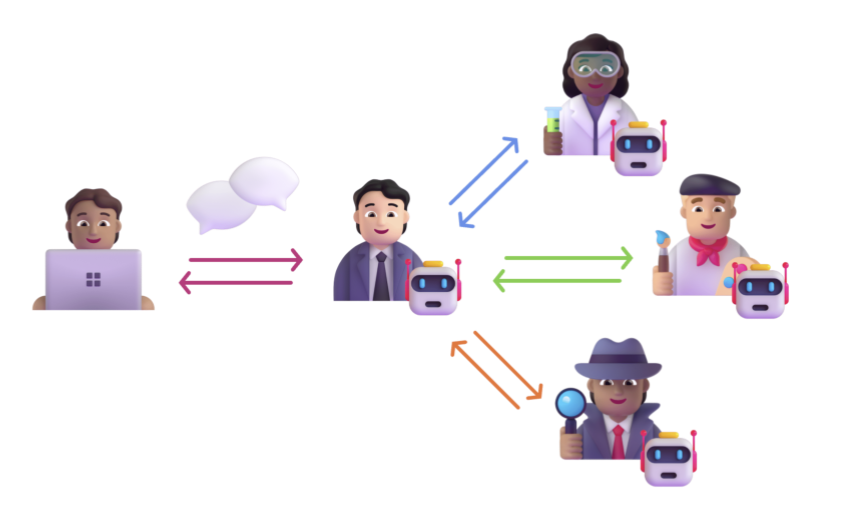

### Initialize the kernel

In [1]:
#r "nuget: Microsoft.SemanticKernel, 1.7.1"
#r "nuget: Microsoft.SemanticKernel.Plugins.Core, 1.7.1-alpha"
#r "nuget: Microsoft.SemanticKernel.Plugins.Web, 1.7.1-alpha"

#!import Settings.cs

using Microsoft.SemanticKernel;
using Microsoft.SemanticKernel.Connectors.OpenAI;

var kernel = Settings.InitializeKernel();

Installed Packages Microsoft.SemanticKernel, 1.7.1 Microsoft.SemanticKernel.Plugins.Core, 1.7.1-alpha Microsoft.SemanticKernel.Plugins.Web, 1.7.1-alpha

Error: (3,19): error CS0246: The type or namespace name 'Kernel' could not be found (are you missing a using directive or an assembly reference?)
(15,19): error CS0246: The type or namespace name 'AzureOpenAIChatCompletionService' could not be found (are you missing a using directive or an assembly reference?)
(5,22): error CS0103: The name 'Kernel' does not exist in the current context
(17,20): error CS0246: The type or namespace name 'AzureOpenAIChatCompletionService' could not be found (are you missing a using directive or an assembly reference?)

Error: (6,14): error CS0103: The name 'Settings' does not exist in the current context

In [ ]:
var agent = new ChatCompletionAgent(
    kernel,
    instructions: "You act as a professional financial adviser. However, clients may not know the terminology, so please provide a simple explanation.",
    new OpenAIPromptExecutionSettings
    {
        MaxTokens = 500,
        Temperature = 0.7,
        TopP = 1.0,
        PresencePenalty = 0.0,
        FrequencyPenalty = 0.0,
    }
 );

var prompt = PrintPrompt("I need help with my investment portfolio. Please guide me.");
PrintConversation(await agent.InvokeAsync([new ChatMessageContent(AuthorRole.User, prompt)]));

### Agents collaboration

## Hierarchical

In [ ]:
List<IAgent> agents = [];
IAgentThread? thread = null;

string[] scriptSteps = [];

var newsPlugin = KernelPluginFactory.CreateFromType<AlertsPlugin>();

var jackAgent = Track(await new AgentBuilder()
    //.WithOpenAIChatCompletion(Env.Var("OpenAI:ModelId")!, Env.Var("OpenAI:ApiKey")!)
    .WithAzureOpenAIChatCompletion(Env.Var("AzureOpenAI:Endpoint")!, Env.Var("AzureOpenAI:ChatCompletionDeploymentName")!, Env.Var("AzureOpenAI:ApiKey")!)
    .FromTemplatePath(@"Agents/HierarchicalAgents.JackSparrowDialogAgent.yaml")
    .WithPlugin(newsPlugin)
    .BuildAsync());

var yodaAgent = Track(await new AgentBuilder()
    //.WithOpenAIChatCompletion(Env.Var("OpenAI:ModelId")!, Env.Var("OpenAI:ApiKey")!)
    .WithAzureOpenAIChatCompletion(Env.Var("AzureOpenAI:Endpoint")!, Env.Var("AzureOpenAI:ChatCompletionDeploymentName")!, Env.Var("AzureOpenAI:ApiKey")!)
    .FromTemplatePath(@"Agents/HierarchicalAgents.YodaDialogAgent.yaml")
    .WithPlugin(newsPlugin)
    .BuildAsync());

var dialogWriterAgent = Track(await new AgentBuilder()
    //.WithOpenAIChatCompletion(Env.Var("OpenAI:ModelId")!, Env.Var("OpenAI:ApiKey")!)
    .WithAzureOpenAIChatCompletion(Env.Var("AzureOpenAI:Endpoint")!, Env.Var("AzureOpenAI:ChatCompletionDeploymentName")!, Env.Var("AzureOpenAI:ApiKey")!)
    .FromTemplatePath(@"Agents/HierarchicalAgents.DialogWriterAgent.yaml")
    .WithPlugin(jackAgent.AsPlugin())
    .WithPlugin(yodaAgent.AsPlugin())
    .BuildAsync());

var result = new List<string>();

thread = await dialogWriterAgent.NewThreadAsync();
Log.Information($"DIALOG START (hierarchical agents, thread id: {thread.Id})");
Log.Information("****************************************");

foreach (var messages in scriptSteps.Select(m => thread!.InvokeAsync(dialogWriterAgent, m)))
{
    await foreach (var message in messages)
    {
        PrintHelper.PrintMessage(message!);
        result.Add($"{message.Role} > {message.Content}");
    }
}

string? step;
do
{
    Console.WriteLine("Enter a script line (or just hit Enter to quit):");
    step = Console.ReadLine();
    if (step is not null)
    {
        var msgs = thread!.InvokeAsync(dialogWriterAgent, step!);
        await foreach (var message in msgs)
        {
            PrintHelper.PrintMessage(message!);
            result.Add($"{message.Role} > {message.Content}");
        }
    }
} 
while (!string.IsNullOrEmpty(step));


IAgent Track(IAgent agent)
{
    agents.Add(agent);

    return agent;
}

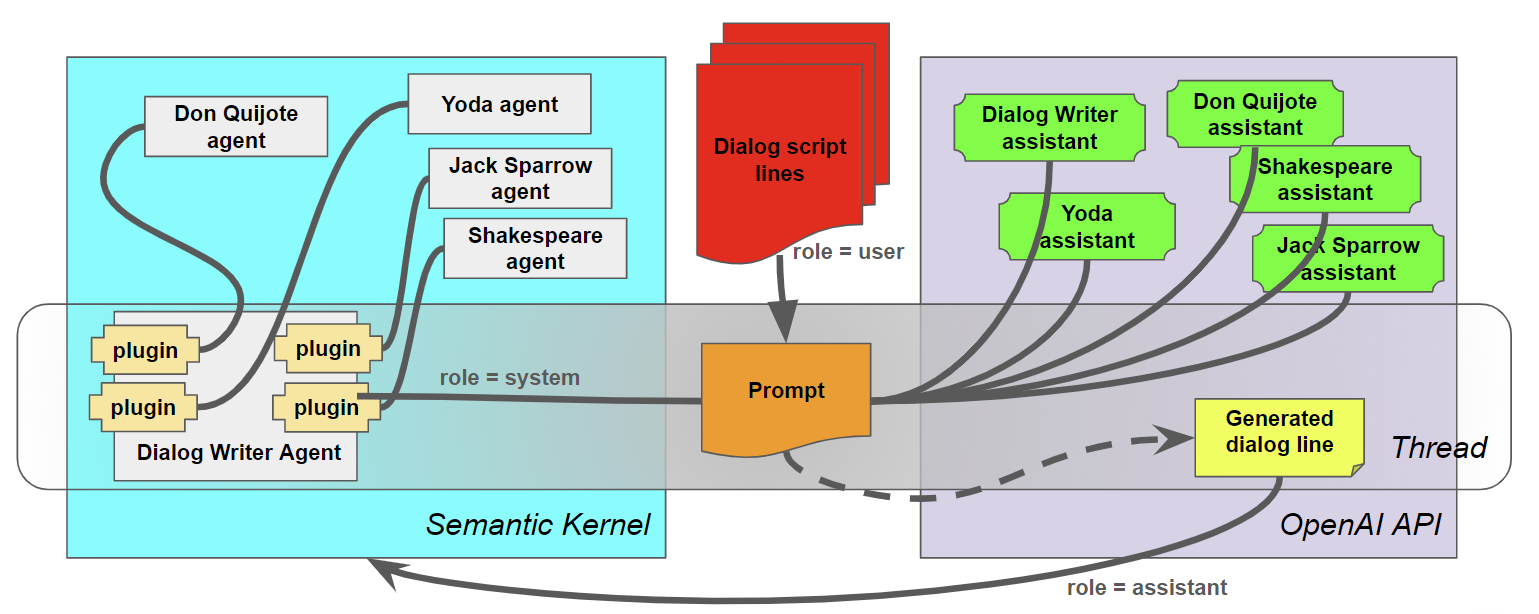